# Dummy Data for Timesiri Cohort

Below, we create two dummy sets for use with Timesiri app-- inspired by actual data on checking account sales:

1. a dataset where modeled residuals follow a white noise process:
2. a dataset where modeled residuals follow an AR(1) process.

Both share the linear model:

$$ Y_t = \beta_0 + 3X_{1,t} + 437X_{2,t} + 0.00184X_{3, t-1} + \epsilon_t$$

where $Y_t = period\ account\ sales$, $X_1 = time\ trend$, $X_2 = business\ days\ in\ period$, and $X_3 = marketing$.

The datasets also include confounding variables and highly-collinear variables.

## Simulating Account Sales
Account sales are simulated using the model, above. $\mu$ is generated using draws from a Poisson distribution; $\epsilon$ is generated using a Poisson distribution. In the second dataset, an AR(1) process is also added to account sales.

### Simulating Trend
Trend is simulated using:

$$ X_t = 3 period_t + \epsilon_t $$

### Simulating Sales per Business Day
Sales per business day simulated using:

$$ X_t = 437 BusinessDays_t + \epsilon_t $$

### Simulated Marketing-Related Sales
Sales from marketing efforts simulated using:

$$ X_t = BaseMarketing_t + TrendMarketing_t + SeasonalMarketing_t $$

where the base marketing level is drawn from N(1e6, 1e4), trend marketing generated from $X_t = 5000 period_t$, and seasonal marketing is 30% of base in Jan, Feb and Mar.

### Simulating AR(1) Process
The AR process is simulated using:

$$ X_t = 0.85 X_{t-1} + Z_t $$

## Other Features
Other features are meant to be confounding and to add collinearity:

1. Accumulated marketing spend
2. Period index
3. January binary indicator
4. Additional marketing binary indicator

## Final Dataset
The final dataset schema is:

|Column|Description|
|------|-----------|
|total_sales|Total sales in month.|
|mkt_spend|Marketing expenditures in month.|
|accum_mkt_spend|Accumulated marketing expenditures from start to present month.|
|index|Period index ranging from 1 to 120|
|jan_ind|Indicator (1 or 0) for January.|
|mkting_ind|Indicator (1 or 0) for Q1|
|bus_days|Number of business days in month.|

# Preliminaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import holidays
from statsmodels.tsa.arima_process import arma_generate_sample

In [2]:
def get_datetime_features(ts):
    assert isinstance(ts.index, pd.DatetimeIndex), 'Time series index must be type=DatetimeIndex'
    assert ts.shape[1] == 1, 'Time series must be shape (n_samples, 1)'

    ts_freq = pd.infer_freq(ts.index)
    ts_tgt = ts.columns[0]

    df = pd.DataFrame()

    df['year'] = ts.index.year
    df['month'] = ts.index.month
    if ts_freq is 'D':
        df['week'] = ts.index.week
        df['weekday'] = ts.index.weekday
    df['quarter'] = ts.index.quarter
    df['days_in_month'] = ts.index.days_in_month
    df['leap_year'] = ts.index.is_leap_year

    df['bus_days'] = pd.Series(ts.index).apply(get_busdays_in_month)

    df.index = ts.index
    return df


def get_busdays_in_month(date):
    if date.is_month_start:
        month_begin = date
    else:
        month_begin = date - pd.tseries.offsets.MonthBegin()
    next_month = month_begin + pd.tseries.offsets.MonthBegin(1)

    holiday_year = date.year
    us_holidays = [*holidays.US(years=holiday_year)]
    busdays = np.busday_count(
        month_begin.date(), next_month.date(), holidays=us_holidays
    )
    return int(busdays)


def get_wei_features(ts):
    assert isinstance(ts.index, pd.DatetimeIndex), 'Time series index must be type=DatetimeIndex'
    assert ts.shape[1] == 1, 'Time series must be shape (n_samples, 1)'

    df = pd.DataFrame()

    df['index'] = [x for x in range(1, len(ts)+1)]
    df['jan'] = [1 if x.month == 1 else 0 for x in ts.index]
    df['marketing'] = [1 if x.quarter == 1 else 0 for x in ts.index]
    df['bus_days'] = pd.Series(ts.index).apply(get_busdays_in_month)

    df.index = ts.index
    return df


# Data Generation

## Set Length and Coefficients

In [3]:
n_obs = 121
ar_coef = 0.85
trend_coef = 3
busday_coef = 437
marketing_coef = 0.00184

## Generate Base Sales and AR(1) Process

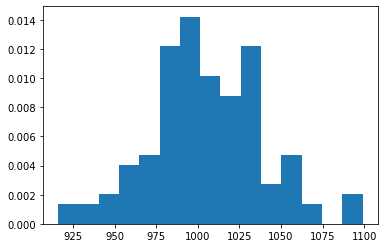

In [4]:
rng = np.random.default_rng()
dist = rng.poisson(1000, n_obs)
count, bins, _ = plt.hist(dist, 15, density=True)
plt.show()

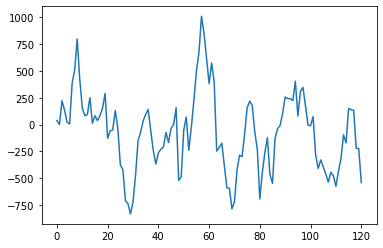

In [5]:
ar_process = arma_generate_sample(
    ar=[1, -ar_coef],
    ma=[1, 0],
    nsample=n_obs,
    scale=200
)
plt.plot(ar_process)
plt.show()

## Create DataFrame, Generate Trend and Sales per Business Days

In [6]:
data = pd.DataFrame(
    {
        'base': dist,
        'ar_process': ar_process.astype(int)
    },
    index = pd.date_range(end='2020-12-31', freq='M', periods=n_obs)
)
data.index.name = 'date'
data['period'] = [*range(1, 122)]
data['trend'] = [x * trend_coef + rng.poisson(100) for x in data['period']]
data['bus_days'] = [get_busdays_in_month(x) for x in data.index]
data['sales_busday'] = data['bus_days'] * busday_coef + rng.poisson(200, n_obs)

In [7]:
data.head()

,base,ar_process,period,trend,bus_days,sales_busday
date,,,,,,
2010-12-31,1005,38,1,120,21,9390
2011-01-31,1022,1,2,106,20,8914
2011-02-28,982,221,3,113,19,8466
2011-03-31,1037,136,4,119,23,10261
2011-04-30,1001,23,5,125,21,9379


## Generate Base Marketing, Marketing Trend and Seasonality

In [8]:
marketing_base = rng.normal(1e6, 1e4, 121)

In [9]:
marketing_trend = [x * 5e3 for x in range(1, n_obs+1)]

In [10]:
marketing = pd.DataFrame(
    {
        'base': marketing_base,
        'trend': marketing_trend
    },
    index=data.index
)
marketing['seasonality'] = np.where(marketing.index.month <=3, marketing['base'] * .30, 0)
marketing['total'] = marketing.sum(axis=1)

In [11]:
marketing.head()

,base,trend,seasonality,total
date,,,,
2010-12-31,1.000544e+06,5000.0,0.000000,1.005544e+06
2011-01-31,1.013253e+06,10000.0,303975.782551,1.327228e+06
2011-02-28,9.983586e+05,15000.0,299507.576483,1.312866e+06
2011-03-31,9.921238e+05,20000.0,297637.137059,1.309761e+06
2011-04-30,1.013189e+06,25000.0,0.000000,1.038189e+06


In [12]:
data['marketing'] = marketing['total']
data['sales_marketing'] = (data['marketing'].shift(1) * marketing_coef) + rng.poisson(200, n_obs)
data.head()

,base,ar_process,period,trend,bus_days,sales_busday,marketing,sales_marketing
date,,,,,,,,
2010-12-31,1005,38,1,120,21,9390,1.005544e+06,NaN
2011-01-31,1022,1,2,106,20,8914,1.327228e+06,2072.201737
2011-02-28,982,221,3,113,19,8466,1.312866e+06,2640.100240
2011-03-31,1037,136,4,119,23,10261,1.309761e+06,2624.673743
2011-04-30,1001,23,5,125,21,9379,1.038189e+06,2606.960106


## Visualize Components

Column: base


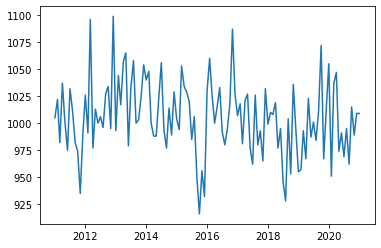

Column: ar_process


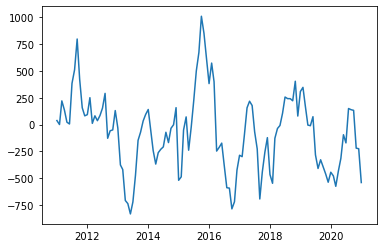

Column: period


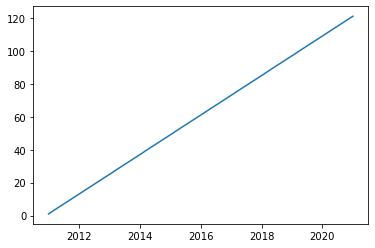

Column: trend


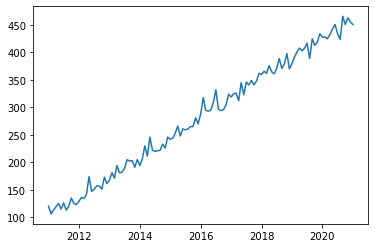

Column: bus_days


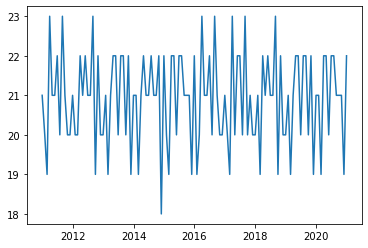

Column: sales_busday


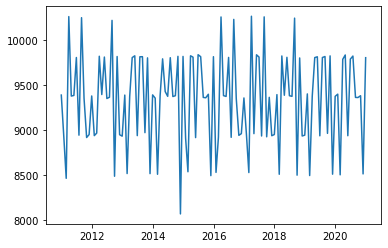

Column: marketing


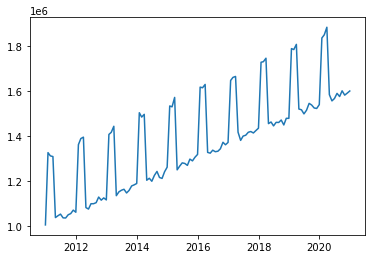

Column: sales_marketing


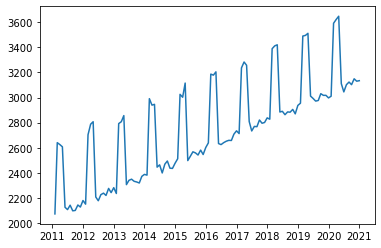

In [13]:
for col in data.columns:
    print(f'Column: {col}')
    plt.plot(data[col])
    plt.show()

## Create Total Sales w/AR(1) Process


In [14]:
total_sales = data.fillna(0)[['base', 'ar_process', 'trend', 'sales_busday', 'sales_marketing']].sum(axis=1)
poisson_noise = rng.poisson(500, n_obs)
data['total_sales'] = total_sales.astype(int) + poisson_noise

## Create Sample Dataset w/ AR Residuals

In [15]:
sample_data = data[['total_sales', 'marketing']].loc['2011':, :]
sample_data['accum_marketing'] = sample_data['marketing'].expanding().sum()
sample_data = sample_data.merge(get_wei_features(sample_data[['total_sales']]), left_index=True, right_index=True)
sample_data.columns = [
    'total_sales', 'mkt_spend', 'accum_mkt_spend', 'index', 'jan_ind', 'mkting_ind', 'bus_days'
]
sample_data.to_csv('sample_data_ar_resid.csv')
sample_data.head()

,total_sales,mkt_spend,accum_mkt_spend,index,jan_ind,mkting_ind,bus_days
date,,,,,,,
2011-01-31,12635,1.327228e+06,1.327228e+06,1,1,1,20
2011-02-28,12934,1.312866e+06,2.640095e+06,2,0,1,19
2011-03-31,14714,1.309761e+06,3.949855e+06,3,0,1,23
2011-04-30,13569,1.038189e+06,4.988044e+06,4,0,0,21
2011-05-31,13139,1.046518e+06,6.034562e+06,5,0,0,21


In [16]:
sample_data.corr()

,total_sales,mkt_spend,accum_mkt_spend,index,jan_ind,mkting_ind,bus_days
total_sales,1.000000,0.393254,0.472882,0.470309,-0.187367,-0.005765,0.678714
mkt_spend,0.393254,1.000000,0.784505,0.784592,0.280240,0.556985,-0.107797
accum_mkt_spend,0.472882,0.784505,1.000000,0.998415,-0.048254,-0.073361,0.009971
index,0.470309,0.784592,0.998415,1.000000,-0.047873,-0.075003,0.008096
jan_ind,-0.187367,0.280240,-0.048254,-0.047873,1.000000,0.522233,-0.134421
mkting_ind,-0.005765,0.556985,-0.073361,-0.075003,0.522233,1.000000,-0.190972
bus_days,0.678714,-0.107797,0.009971,0.008096,-0.134421,-0.190972,1.000000


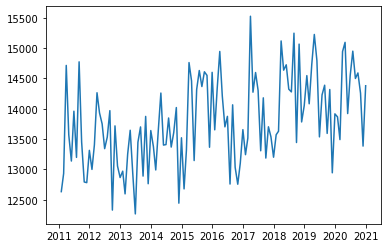

In [17]:
plt.plot(sample_data['total_sales'])
plt.show()

## Create Total Sales

In [18]:
total_sales = data.fillna(0)[['base', 'trend', 'sales_busday', 'sales_marketing']].sum(axis=1)
poisson_noise = rng.poisson(500, n_obs)
data['total_sales'] = total_sales.astype(int) + poisson_noise

## Create Sample Dataset w/ White Noise Residuals

In [19]:
sample_data = data[['total_sales', 'marketing']].loc['2011':, :]
sample_data['accum_marketing'] = sample_data['marketing'].expanding().sum()
sample_data = sample_data.merge(get_wei_features(sample_data[['total_sales']]), left_index=True, right_index=True)
sample_data.columns = [
    'total_sales', 'mkt_spend', 'accum_mkt_spend', 'index', 'jan_ind', 'mkting_ind', 'bus_days'
]
sample_data.to_csv('sample_data.csv')
sample_data.head()

,total_sales,mkt_spend,accum_mkt_spend,index,jan_ind,mkting_ind,bus_days
date,,,,,,,
2011-01-31,12608,1.327228e+06,1.327228e+06,1,1,1,20
2011-02-28,12769,1.312866e+06,2.640095e+06,2,0,1,19
2011-03-31,14562,1.309761e+06,3.949855e+06,3,0,1,23
2011-04-30,13606,1.038189e+06,4.988044e+06,4,0,0,21
2011-05-31,13128,1.046518e+06,6.034562e+06,5,0,0,21


In [20]:
sample_data.corr()

,total_sales,mkt_spend,accum_mkt_spend,index,jan_ind,mkting_ind,bus_days
total_sales,1.000000,0.506985,0.589253,0.587895,-0.186579,0.020463,0.724208
mkt_spend,0.506985,1.000000,0.784505,0.784592,0.280240,0.556985,-0.107797
accum_mkt_spend,0.589253,0.784505,1.000000,0.998415,-0.048254,-0.073361,0.009971
index,0.587895,0.784592,0.998415,1.000000,-0.047873,-0.075003,0.008096
jan_ind,-0.186579,0.280240,-0.048254,-0.047873,1.000000,0.522233,-0.134421
mkting_ind,0.020463,0.556985,-0.073361,-0.075003,0.522233,1.000000,-0.190972
bus_days,0.724208,-0.107797,0.009971,0.008096,-0.134421,-0.190972,1.000000


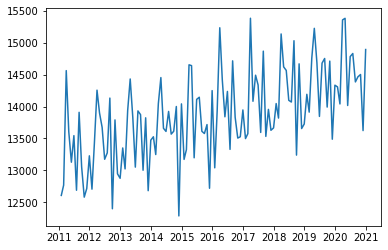

In [21]:
plt.plot(sample_data['total_sales'])
plt.show()

# Test Lasso Model

Timesiri seems to get errors when running regularized models, running LASSO for quick comparison.

In [22]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error

lr = Lasso(max_iter=1e4, alpha=1, normalize=True)
lr.fit(sample_data.loc[:'2018', ['mkt_spend', 'accum_mkt_spend', 'index', 'jan_ind', 'mkting_ind', 'bus_days']], sample_data.loc[:'2018', 'total_sales'])
preds = lr.predict(sample_data.loc['2019':, ['mkt_spend', 'accum_mkt_spend', 'index', 'jan_ind', 'mkting_ind', 'bus_days']])
mean_absolute_error(preds, sample_data.loc['2019':, 'total_sales'])

80.91727696393507

In [23]:
fitted = lr.predict(sample_data.loc[:'2018', ['mkt_spend', 'accum_mkt_spend', 'index', 'jan_ind', 'mkting_ind', 'bus_days']])
actual = sample_data.loc[:'2018', 'total_sales']
mean_absolute_error(fitted, actual)

101.63572352406874

# Simulate True Model

Display MAE and plot Actuals vs Predicted for "true" model.

In [24]:
preds = (
    2000
    + sample_data['mkt_spend'].shift(1) * marketing_coef
    + sample_data['index'] * trend_coef
    + sample_data['bus_days'] * busday_coef
)

In [25]:
mean_absolute_error(
    preds.loc['2019':],
    sample_data.loc['2019':, 'total_sales']
)

29.483393306764963

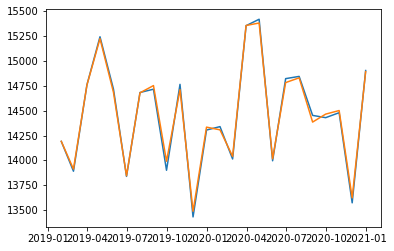

In [26]:
plt.plot(preds.loc['2019':])
plt.plot(sample_data.loc['2019':, 'total_sales'])
plt.show()